In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [1]:
from keras.layers import Conv2D, DepthwiseConv2D, SeparableConv2D
from keras.layers import BatchNormalization, ReLU, GlobalAveragePooling2D
from keras.models import Model
from keras.layers import Dense

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [4]:
val_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [5]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [6]:
dataset_path = 'Split'

In [7]:
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, 'train'),
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical'
)

# Similarly for validation and test generators


Found 8400 images belonging to 5 classes.


In [8]:
val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, 'val'),
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical'
)

Found 2400 images belonging to 5 classes.


In [10]:
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, 'test'),
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical',
)

Found 1200 images belonging to 5 classes.


In [9]:
def mobilenet_block(x, filters, strides=(1, 1)):
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=1, strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x


In [12]:
inputs = tf.keras.Input(shape=(512, 512, 3))  # Adjust input shape if needed

# Initial Convolution
x = Conv2D(32, kernel_size=3, strides=(2, 2), padding='same')(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)

# Stack MobileNet Blocks (Adjust number and filter sizes as needed)
x = mobilenet_block(x, 64)
x = mobilenet_block(x, 64, strides=(3, 3))
x = mobilenet_block(x, 64)

# Final Pooling and Output Layer
x = GlobalAveragePooling2D()(x)
outputs = Dense(units=5, activation='softmax')(x)# Adjust for your task

model = Model(inputs=inputs, outputs=outputs)


In [13]:
model.compile(
    optimizer='adam',  # Choose an optimizer
    loss='categorical_crossentropy',  # Adjust loss based on task
    metrics=['accuracy']
)

In [14]:
history = model.fit(train_generator, epochs=1, validation_data=val_generator)

263/263 [==============================] - 1725s 7s/step - loss: 1.0321 - accuracy: 0.6401 - val_loss: 1.8754 - val_accuracy: 0.1996


In [15]:
from tabulate import tabulate

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

table_data = [(epoch + 1, train_acc,f"{train_acc * 100:.2f}%", val_acc, f"{val_acc * 100:.2f}%") for epoch, (train_acc, val_acc) in enumerate(zip(train_accuracy, val_accuracy))]

headers = ['Epoch', 'Train Accuracy', 'Train Accuracy (%)', 'Validation Accuracy', 'Validation Accuracy (%)']

print(tabulate(table_data, headers=headers, tablefmt='grid'))

+---------+------------------+----------------------+-----------------------+---------------------------+
|   Epoch |   Train Accuracy | Train Accuracy (%)   |   Validation Accuracy | Validation Accuracy (%)   |
+=========+==================+======================+=======================+===========================+
|       1 |         0.640119 | 64.01%               |              0.199583 | 19.96%                    |
+---------+------------------+----------------------+-----------------------+---------------------------+


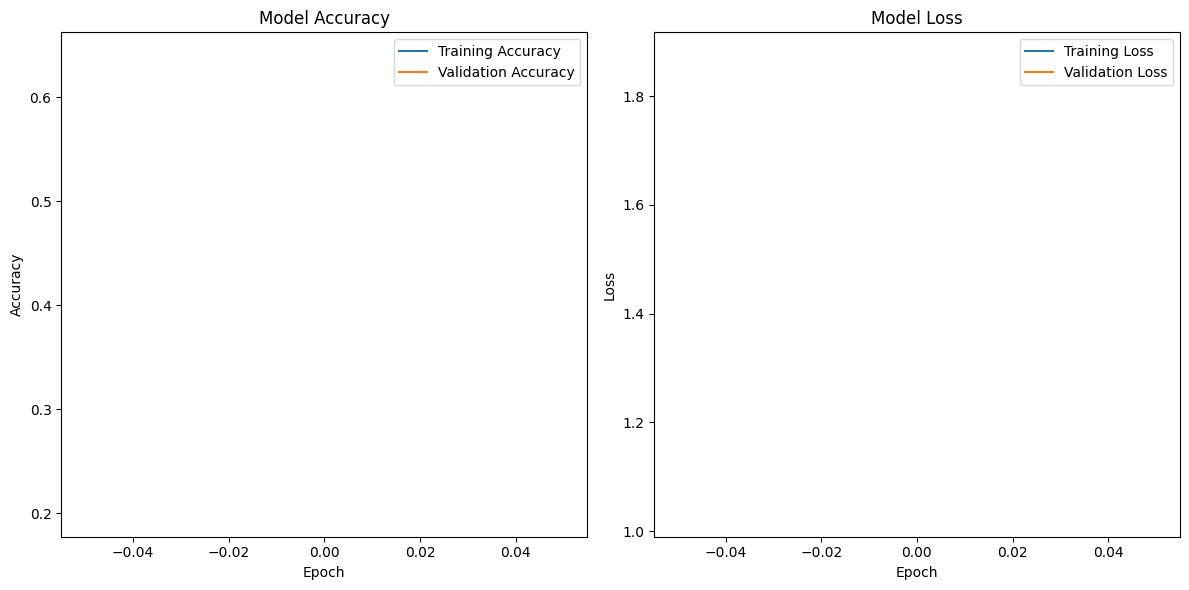

C:\Users\Acer\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

model.save('fruit_classifier_model1.h5')

Found 1200 images belonging to 5 classes.
60/60 [==============================] - 62s 1s/step
F1 Score: 0.1027


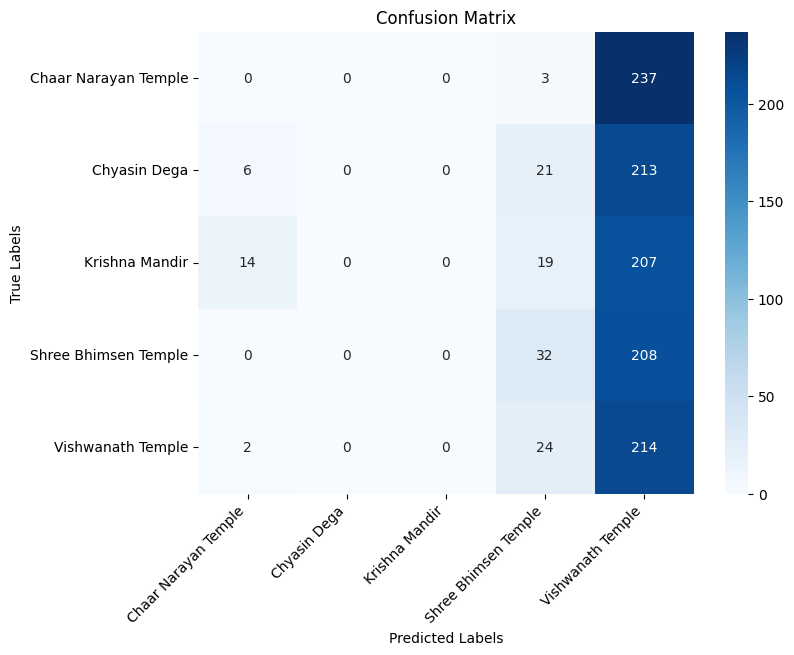

In [17]:

import cv2
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model

# Load the pre-trained model
model_path = r'C:\Users\Acer\Desktop\Minor Project\fruit_classifier_model1.h5'
model = load_model(model_path)

# Set the path to your test dataset
test_data_dir = 'split/test'
img_width, img_height = 512, 512
batch_size = 20

# Data Preprocessing for testing set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)  # Ensure labels are in the same order as predictions

# Get true labels
true_labels = test_generator.classes

# Make predictions
predictions = model.predict(test_generator)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display F1 score
print(f"F1 Score: {f1:.4f}")

# Display Confusion Matrix with rotated x-axis labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices, cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.show()


In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8040966776765949933
xla_global_id: -1
]


In [5]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[]


In [1]:
import tensorflow as tf
tf.__version__

'2.13.0'